## CV Final Project: Interest Point Detector + Descriptor using SURF
Aja Klevs + Micaela Flores

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import time
import scipy
from PIL import Image
import math
import scipy.misc
from scipy.ndimage.interpolation import zoom
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pywt
from scipy import signal

import scipy.ndimage as ndimage #image processing library
import itertools

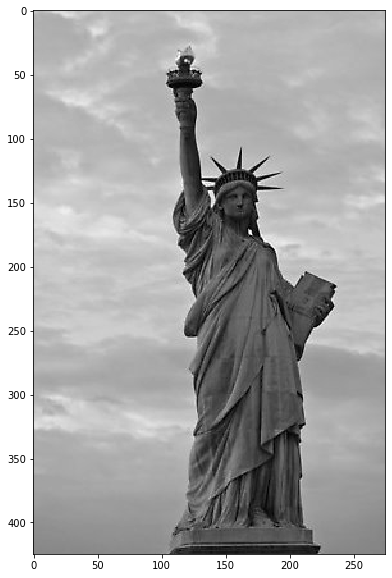

In [3]:
#loading and displaying base image, 'lady'

plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

name = 'lady_liberty1.jpeg'
lady = plt.imread(name)
lady = lady[25:450, 25:300]
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(lady)

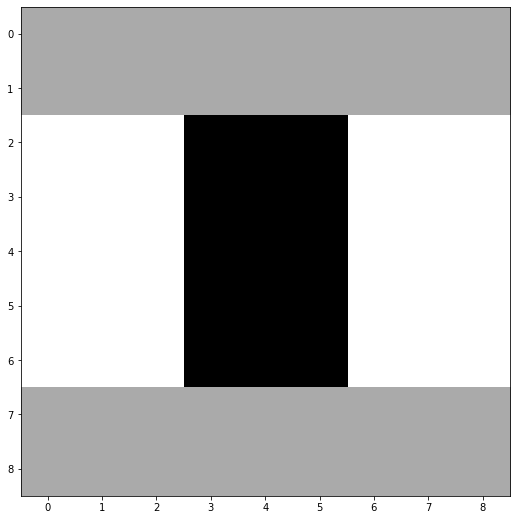

In [4]:
#functions to create block filters at different scales

def DxDy_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(math.ceil(dim/9))
    i1 = ref
    i2 = int(dim/3+(dim/3-3)/2+1)
    i3 = i2+1
    i4 = dim - ref
    
    mask[i1:i2, i1:i2] = 1
    mask[i3:i4, i3:i4] = 1
    mask[i1:i2, i3:i4] = -1
    mask[i3:i4, i1:i2] = -1
    
    return mask

def DyDy_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(dim/3)
    ref2 = math.floor(dim/2)
    i1 = ref
    i2 = 2*ref
    i3 = math.ceil(ref2/2)
    i4 = dim - math.ceil(ref2/2)
    
    mask[0:i1, i3:i4] = 1
    mask[i1:i2, i3:i4] = -2
    mask[i2:dim+1, i3:i4] = 1
    
    return mask

def DxDx_filter(dim):
    mask = np.zeros((dim,dim))
    ref = int(dim/3)
    ref2 = math.floor(dim/2)
    i1 = ref
    i2 = 2*ref
    i3 = math.ceil(ref2/2)
    i4 = dim - math.ceil(ref2/2)
    
    mask[i3:i4, 0:i1] = 1
    mask[i3:i4, i1:i2] = -2
    mask[i3:i4, i2:dim+1] = 1
    
    return mask

#visualizing a random block filter
test = DxDx_filter(9)
plt.figure(figsize=((9,9)))
plt.imshow(test)
plt.show()

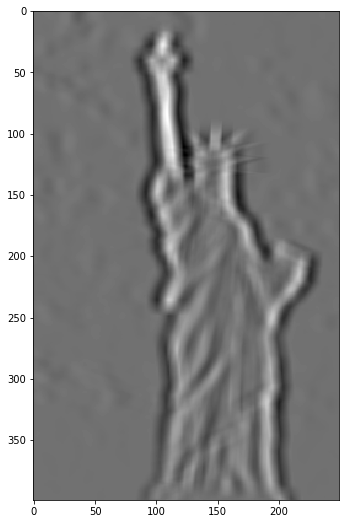

In [10]:
#We wrote our own convolve function, before realizing we could use scipy's convolve2d with mode set to 'valid'
#it works okay but some of the indexing might be off, so we used convolve2d to be safe
def convolve(img,fltr):
    dim1,dim2 = fltr.shape
    half1,half2 = math.floor(dim1/2), math.floor(dim2/2)
    m,n = img.shape
    
    output = np.zeros((m,n))
    
    for i in np.arange(m-2*dim1)+dim1:
        for j in np.arange(n-2*dim2)+dim2:
            box = img[i-half1-1:i+half1, j-half2-1:j+half1]
            output[i][j] = np.sum(box*fltr)
            
    return output

#testing the convolve2d filter
test = signal.convolve2d(lady, DxDx_filter(27), mode='valid')
plt.figure(figsize=((9,9)))
plt.imshow(test)
plt.show()


In [17]:
#We implemented 2 octaves, the first has sigma values of 1.2, 2.4, 3.6, 4.8, 6.0, 7.2, 8.4, and 9.6
#corresponding to filters of size 9, 15, 21, 27, 33, 39, 45, and 51
#The second octave has sigma values of 4.4, 5.6, 6.8, 8.0, 9.2, 10.4, 11.6, and 12.8
#corresponding to filters of size 33,  45,  57,  69,  81,  93, 105, and 117

#at this step we represent each octave as a dictionary were keys are the numbers 1,2,3,4,5,6,7,8
#and the values are the convolved images at that scale.  the functions get_ss_first_octave and
#get_ss_second_octave give a list of s values corresponding the the keys of the octave

def create_first_octave(img, num_layers):
    layers = {}
    dims = np.linspace(9,9+6*(num_layers-1), num_layers)
    count = 0
    for di in dims:
        count += 1
        dim = int(di)
        Dxx = signal.convolve2d(img, DxDx_filter(dim), mode='valid')
        Dxy = signal.convolve2d(img, DxDy_filter(dim), mode='valid')
        Dyy = signal.convolve2d(img, DyDy_filter(dim), mode='valid')
        
        this_scale = np.abs(Dxx*Dyy - ((.9**2)*Dxy*Dxy))
        s = ((dim - 9)/6 + 1)*1.2
        layers[count] = this_scale
    return layers

def create_second_octave(img, num_layers):
    layers = {}
    dims = np.linspace(33,33+12*(num_layers-1), num_layers)
    count = 0
    for di in dims:
        count += 1
        dim = int(di)
        Dxx = signal.convolve2d(img, DxDx_filter(dim), mode='valid')
        Dxy = signal.convolve2d(img, DxDy_filter(dim), mode='valid')
        Dyy = signal.convolve2d(img, DyDy_filter(dim), mode='valid')
        
        this_scale = np.abs(Dxx*Dyy - ((.9**2)*Dxy*Dxy))
        s = ((dim - 9)/6 + 1)*1.2
        layers[count] = this_scale
    return layers

def get_ss_first_octave(num_layers):
    return np.linspace(1.2, 1.2*num_layers, num_layers)

def get_ss_second_octave(num_layers):
    return np.linspace(4.4, 1.6*num_layers, num_layers)
        

start_time = time.time()
first_octave = create_first_octave(lady, 8)
print('time to make first octave:', time.time() - start_time, 'seconds')
start_time = time.time()
second_octave = create_second_octave(lady, 8)
print('time to make second octave:' ,time.time() - start_time, 'seconds')
print('')
print('s (sigma) values for the first octave:')
print(get_ss_first_octave(8))
print('')
print('s (sigma) values for the second octave:')
print(get_ss_second_octave(8))

time to make first octave: 5.730930805206299 seconds
time to make second octave: 22.817343950271606 seconds

s (sigma) values for the first octave:
[1.2 2.4 3.6 4.8 6.  7.2 8.4 9.6]

s (sigma) values for the second octave:
[ 4.4  5.6  6.8  8.   9.2 10.4 11.6 12.8]


#################################
First Octave Convolved Images:
#################################


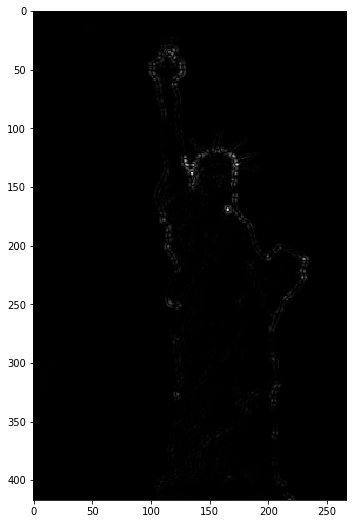

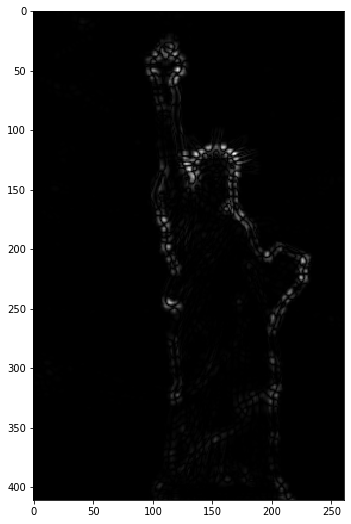

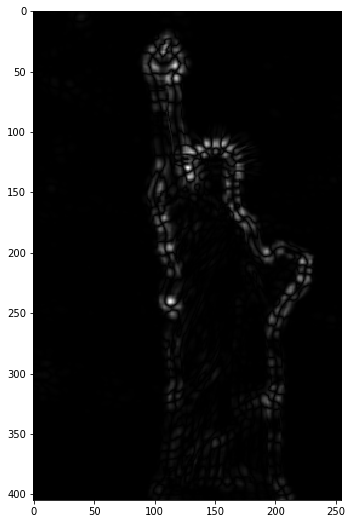

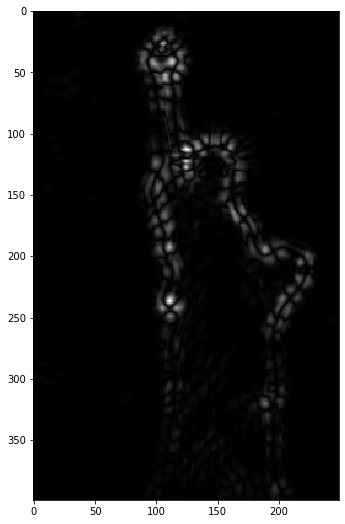

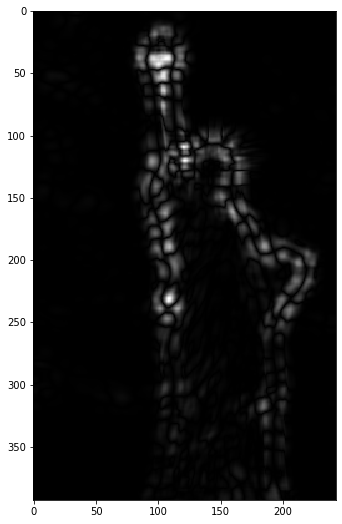

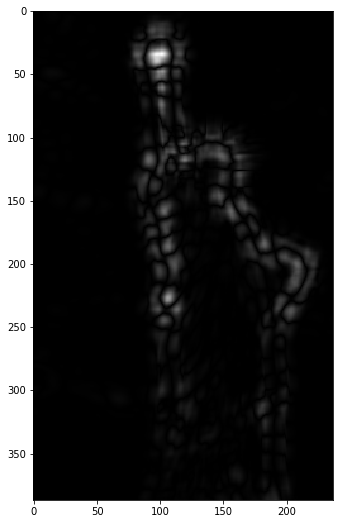

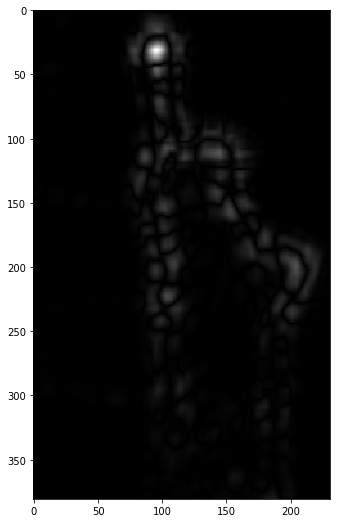

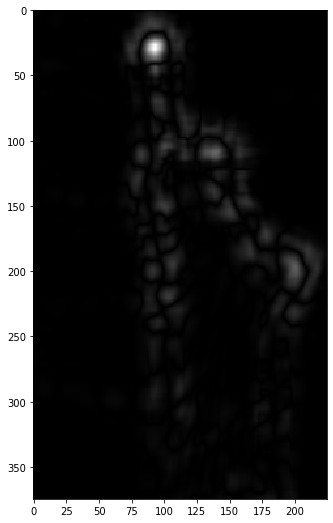

#################################
Second Octave Convolved Images:
#################################


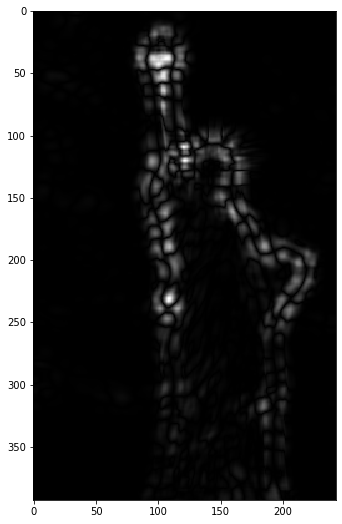

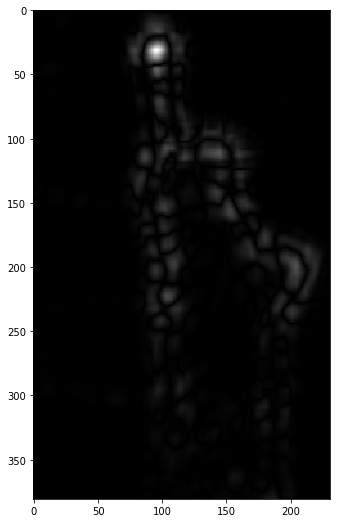

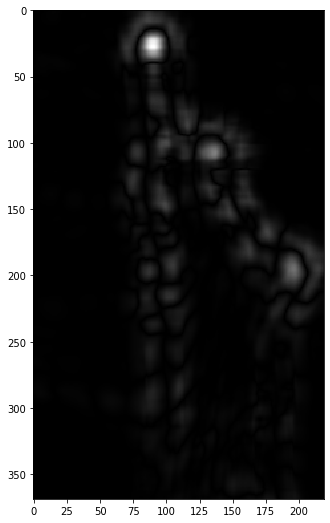

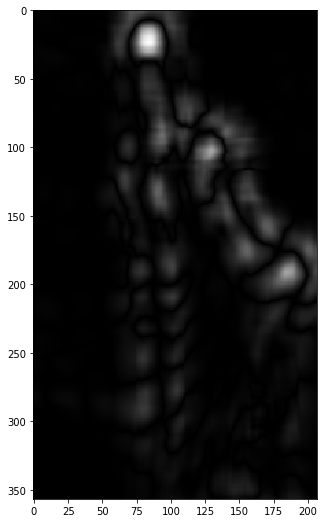

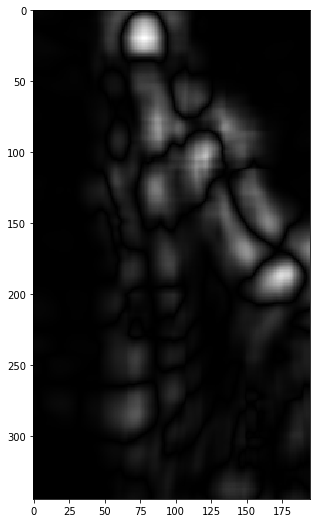

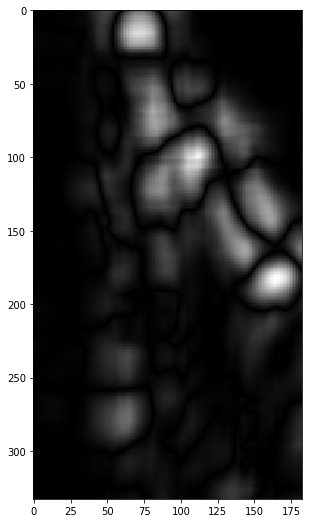

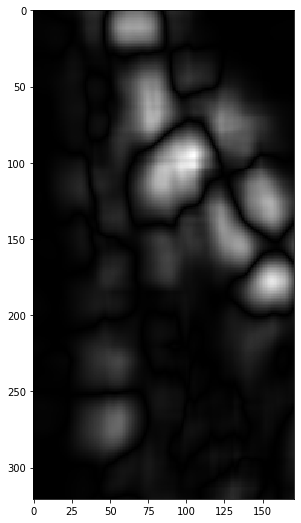

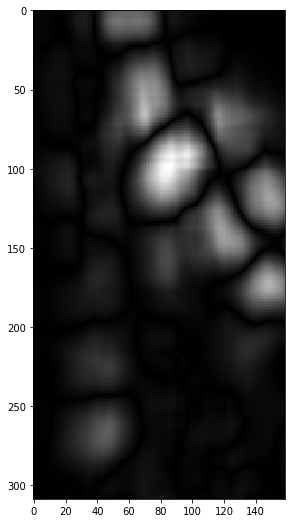

In [20]:
#visualizing each octave
print('#################################')
print('First Octave Convolved Images:')
print('#################################')
for layer in first_octave.keys():
    plt.figure(figsize=((9,9)))
    plt.imshow(first_octave[layer])
    plt.show()
print('#################################')
print('Second Octave Convolved Images:')
print('#################################')
for layer in second_octave.keys():
    plt.figure(figsize=((9,9)))
    plt.imshow(second_octave[layer])
    plt.show()
    

#################################
The thresholded layers of the first octave:
#################################


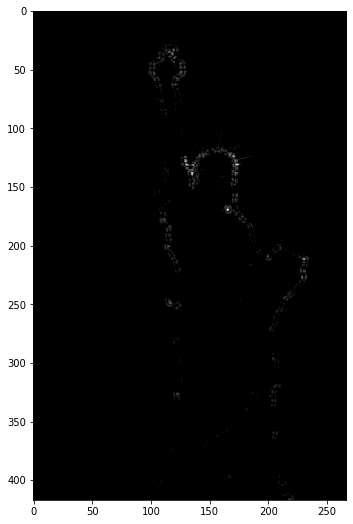

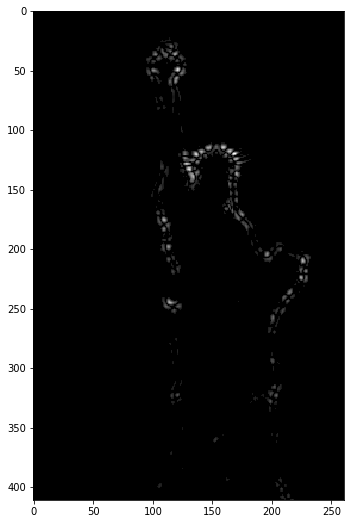

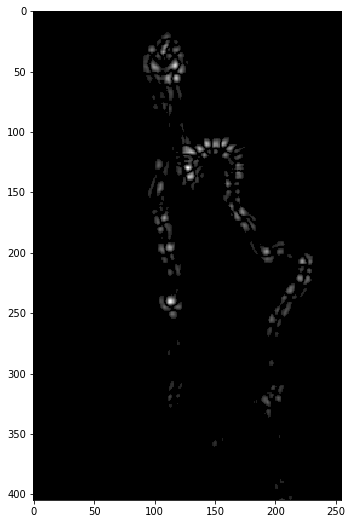

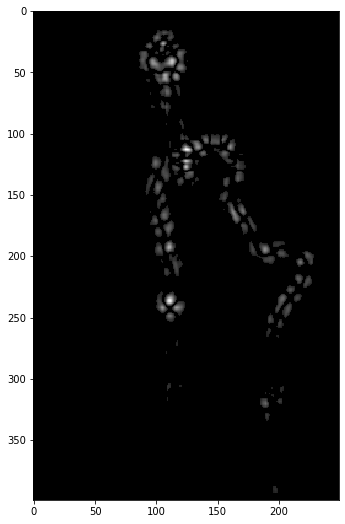

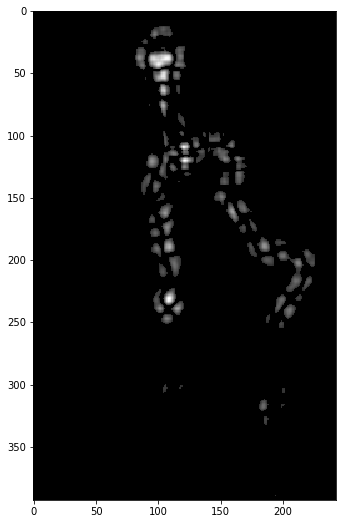

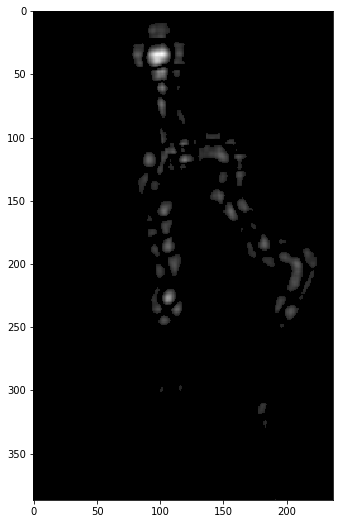

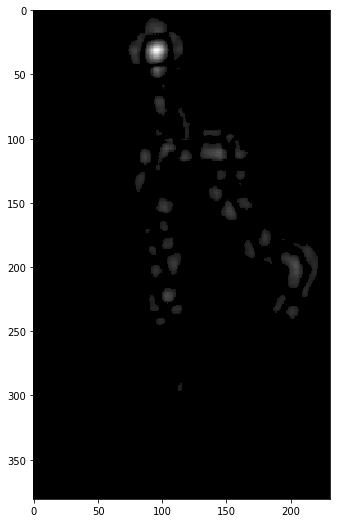

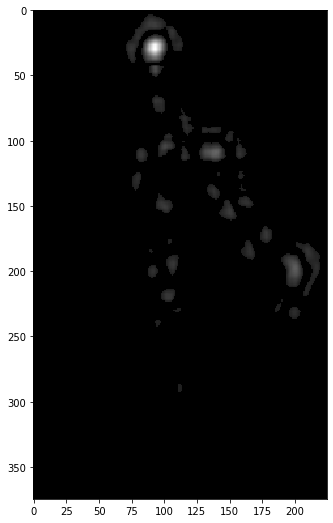

#################################
The thresholded layers of the second octave:
#################################


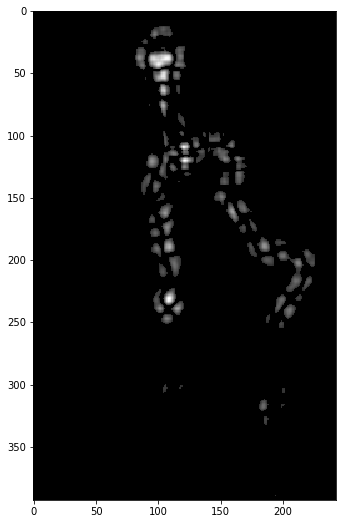

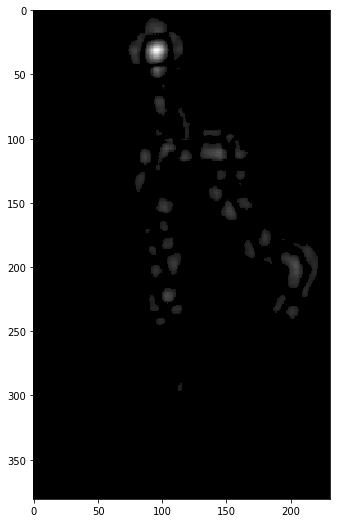

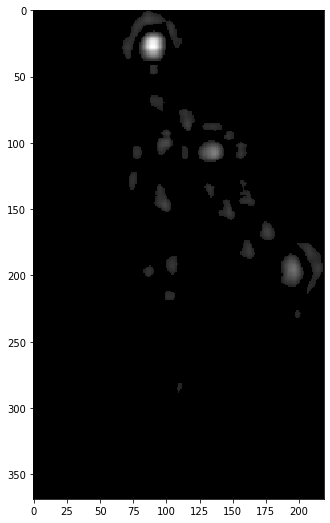

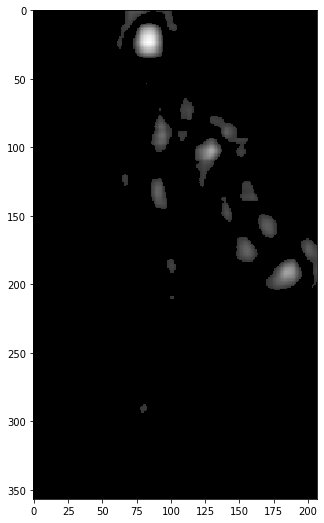

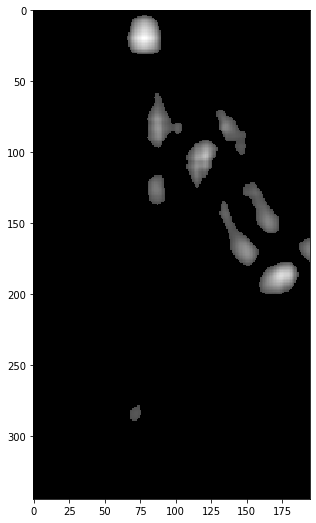

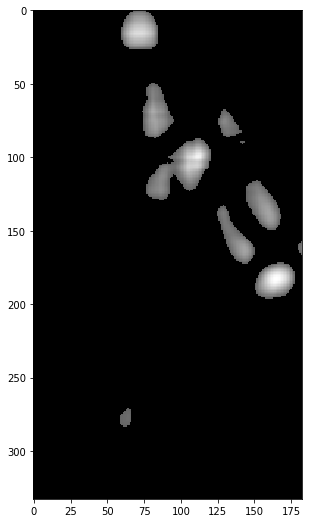

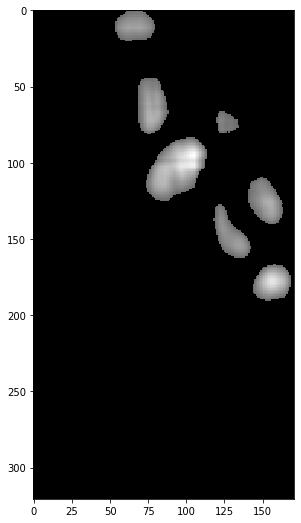

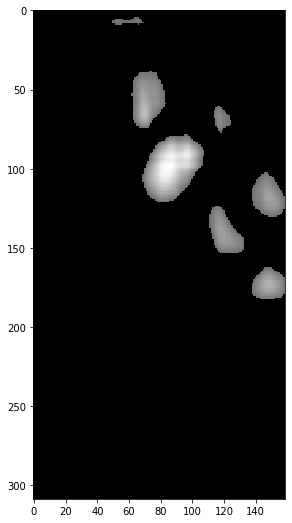

In [21]:
#threshold only keeps the points that are above 2 standard deviations of that layer
#of the octave.  Results are visualized below

def threshold(filtered_image):
    max_pixel = np.max(filtered_image)
    mean = np.mean(filtered_image)
    sd = np.std(filtered_image)
    mask = 1*(filtered_image > (mean + 2*sd))
    return mask*filtered_image

print('#################################')
print('The thresholded layers of the first octave:')
print('#################################')
thresholded_first_octave = {}
for layer in first_octave.keys():
    plt.figure(figsize=((9,9)))
    thresholded_first_octave[layer] = threshold(first_octave[layer])
    plt.imshow(thresholded_first_octave[layer])
    plt.show()
    
print('#################################')
print('The thresholded layers of the second octave:')
print('#################################')
thresholded_second_octave = {}
for layer in second_octave.keys():
    plt.figure(figsize=((9,9)))
    thresholded_second_octave[layer] = threshold(second_octave[layer])
    plt.imshow(thresholded_second_octave[layer])
    plt.show()

In [46]:
#This cell is functions we utilize to perform the max suppression

def surround_pts(j,k,lyr):
    return [lyr[j-1][k-1],lyr[j-1][k],lyr[j-1][k+1],lyr[j][k-1],lyr[j][k+1],lyr[j+1][k-1],lyr[j+1][k],lyr[j+1][k+1]]

def check_point(j,k,previous_layer, current_layer, next_layer):
    this_point = current_layer[j][k]
    
    previous_pts = surround_pts(j,k,previous_layer)
    previous_pts.append(previous_layer[j][k])
    
    current_pts = surround_pts(j,k, current_layer)
    
    next_pts = surround_pts(j,k, next_layer)
    next_pts.append(next_layer[j][k])
    
    all_points = previous_pts + current_pts + next_pts
    
    for point in all_points:
        if this_point <= point:
            return False
    
    return True

def find_interest_points(octave, first_or_second):
    num_layers = len(octave.keys())
    if first_or_second ==1:
        scales = get_ss_first_octave(num_layers)
    elif first_or_second ==2:
        scales = get_ss_second_octave(num_layers)
    interest_points = {}
    m,n = octave[1].shape
    for i in np.arange(num_layers-2)+2:
        previous_layer = octave[i-1]
        current_layer = octave[i]
        next_layer = octave[i+1]
    
        for j in np.arange(m-21)+10:
            for k in np.arange(n-21)+10:
                if check_point(j,k,previous_layer,current_layer,next_layer):
                    interest_points[(j,k)] = scales[i]
                    
    return interest_points

In [47]:
print(layers.keys())
start_time = time.time()
first_octave_interest_points = find_interest_points(thresholded_first_octave, 1)
print(time.time() - start_time)

print(layers.keys())
start_time = time.time()
second_octave_interest_points = find_interest_points(thresholded_second_octave, 2)
print(time.time() - start_time)

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])
8.694598197937012
dict_keys([1, 2, 3, 4, 5, 6, 7, 8])
8.379894971847534


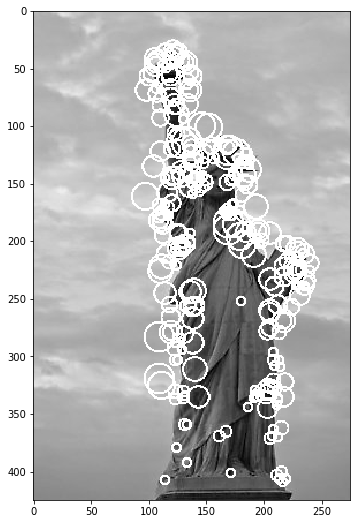

In [52]:

def illustrate_point(img, pt, radius):
    r = math.ceil(radius)
    output = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            output[i][j] = img[i][j]
    x,y = pt
    window = img[x-r-1:x+r+1, y-r-1:y+r+1]
    m,n = window.shape
    for i in np.linspace(x-r-1, x+r+1, x+r+1 - (x-r-1) + 1):
        for j in np.linspace(y-r-1, y+r+1, y+r+1 - (y-r-1) + 1):
            length = np.sqrt((i-x)**2 + (j - y)**2)
            if radius-1 < length < radius+1:
                output[int(i)][int(j)] = 255
                
    return output

def s2pixelsize(s):
    layer_num = (s/1.2)-2
    return int(9 + layer_num*6)


copy = lady
for pt in first_octave_interest_points.keys():
    copy = illustrate_point(copy, pt, first_octave_interest_points[pt])
for pt in second_octave_interest_points.keys():
    copy = illustrate_point(copy, pt, second_octave_interest_points[pt])

plt.figure(figsize=((9,9)))
plt.imshow(copy)
plt.show()
        

In [76]:
print(len(first_octave_interest_points.keys()))
print(len(second_octave_interest_points.keys()))

170
82


In [86]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [ ]:
def get_box_for_descriptor(img, i,j, orientation):
    box = np.zeros((20,20))
    if orientation == 'pi/8':
        for row in np.arange(20):
            s = math.floor(row/2)
            box[row] = img[i-4+s,j-5+s],img[i-3+s,j-6+s],img[i-2+s,j-7+s],img[i-1+s,j-8+s],img[i+s, j-9+s]

In [53]:
def haar_wavelet_filter(dim, direction='x'):
    fltr = np.ones((dim,dim))
    halfway = dim//2
    
    if direction == 'x':
        #set -1 region
        fltr[:,0:halfway] = -1
    
    elif direction == 'y':
        #set -1 region
        fltr[0:halfway,:] = -1
    
    return fltr

In [73]:
def haar_wavelet_filter(dim, direction='x'):
    fltr = np.ones((dim,dim))
    halfway = dim//2
    
    if direction == 'x':
        #set -1 region
        fltr[:,0:halfway] = -1
    
    elif direction == 'y':
        #set -1 region
        fltr[0:halfway,:] = -1
    
    return fltr

#only works for 5x5 images
def haar_wavelet_response(img):
    dx,dy = haar_wavelet_filter(4, 'x'), haar_wavelet_filter(4, 'y')
    
    first = img[0:4,0:4]
    second = img[0:4,1:5]
    third = img[1:5,0:4]
    fourth = img[1:5,1:5]
    
    dx_response = np.array([[np.sum(dx*first),np.sum(dx*second)],[np.sum(dx*third), np.sum(dx*fourth)]])
    dy_response = np.array([[np.sum(dy*first),np.sum(dy*second)],[np.sum(dy*third), np.sum(dy*fourth)]])
    
    return dx_response, dy_response
    

haar_wavelet_response(lady[5:10, 20:25])

(array([[24., 55.],
        [ 2., 21.]]), array([[-36., -61.],
        [ -2., -15.]]))

In [75]:
import itertools

dy_filter = np.array([[-1,-1,-1,-1],[-1,-1,-1,-1],[1,1,1,1],[1,1,1,1]])
dx_filter = np.array(([[-1,-1,1,1],[-1,-1,1,1],[-1,-1,1,1],[-1,-1,1,1]]))

def get_descripter(interest_region):
    descripter = []
    indices = [(0,5),(5,10),(10,15),(15,20)]
    for region in list(itertools.product(indices,indices)):
        sample = interest_region[region[0][0]: region[0][1], region[1][0]: region[1][1]]
        Dx, Dy = haar_wavelet_response(sample)
        descripter += [np.sum(Dx), np.sum(Dy), np.sum(np.abs(Dx)), np.sum(np.abs(Dx))]
        
    return descripter
    
    
len(get_descripter(lady[5:25,35:55]))

64

In [13]:
'''
@description: this function gets the points in a circular region around an interest point
@params: img - the image to get the circular points around
         center - the interest point around which to get the points
         scale - the scale s to multiply by 6 (radius = 6*s)
@return: circular_pts - list of tuples of the surrounding points in the circular region
'''
def get_circular_pts(img, center, scale):
    radius = 6*scale
    h,w = img.shape
    X, Y = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    circular_pts = list(zip(*np.where(mask != 0)))
    
    return circular_pts

In [ ]:
def haar_wavelet(img, interest_pt, scale, direction='x'):
    i,j = interest_pt #indices of current interest point
    circular_region = get_circular_pts(img,interest_pt,scale) #list of all surrounding pixels
    response = 0
    
    if direction == 'x':
        above_sum = 0
        below_sum = 0
        
        for pt in circular_region: #pt = (40,107) for example
            i_prime,j_prime = pt #indices of current point
             
            if i_prime < i: #if this point is above interest_point
                above_sum += img[i_prime][j_prime]
            elif i_prime > i: #if this point is below interest_point
                #make sure the below sum is the negative sum
                below_sum -= img[i_prime][j_prime]
        
        #add them together and assign the interest point with this resulting value
        response = above_sum + below_sum
    
    elif direction == 'y':
        left_sum = 0
        right_sum = 0
        
        for pt in circular_region: #pt = (40,107) for example
            i_prime,j_prime = pt #indices of current point

            if j_prime < j: #if this point is to the left of interest_point
                left_sum += img[i_prime][j_prime]
            elif j_prime > j: #if this point is to the right of interest_point
                #make sure the below sum is the negative sum
                right_sum -= img[i_prime][j_prime]
                
        #add them together and assign the interest point with this resulting value
        response = left_sum + right_sum
        
    return response

In [136]:
def find_distance(pt, center, perpendicular):
    v1 = pt-center
    v2 = perpendicular
    factor = np.dot(v1,v2)/(np.linalg.norm(v2)**2)
    projection = v1 - factor*v2
    return np.linalg.norm(projection)

def square_around_pt(img, center, radius):
    center = np.array(center)
    r = radius
    int_r = math.floor(r)
    adjusted_r = math.floor(r/np.sqrt(2))
    circle = get_circular_pts(img, center, r)
    output = []
    
    perpendicular = np.array([1,-1])
    parallel = np.array([-1,-1])
    for pt in circle:
        d1 = find_distance(np.array(pt), center, perpendicular)
        d2 = find_distance(np.array(pt), center, parallel)
        if d1 < adjusted_r and d2 < adjusted_r:
            output.append(pt)   
    
    return np.array(output)

29


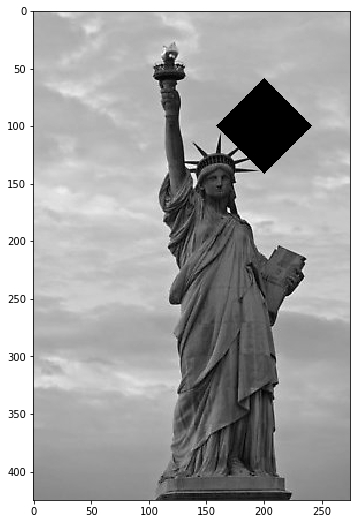

In [119]:
region = square_around_pt(lady,[100,200],42)

copy = np.ones(copy.shape)
for i in range(copy.shape[0]):
    for j in range(copy.shape[1]):
        copy[i][j] = lady[i][j]
        
for pt in region:
    copy[pt[0]][pt[1]] = 0
    
plt.figure(figsize=((9,9)))
plt.imshow(copy)
plt.show()   

In [177]:
def get_descriptor_centers(img, center, orientation, s):
    i,j = center
    box_dim = 4*s/np.sqrt(2)
    up1 = math.ceil(box_dim)
    up2 = math.ceil(2*box_dim)
    up3 = math.ceil(3*box_dim)
    
    centers = {}
    if orientation == '7pi/4':
        centers[4] = (i + up3,j)
        centers[3] = (i + up2, j+up1)
        centers[2] = (i + up1, j+up2)
        centers[1] = (i, j+ up3)
        
        centers[8] = (i + up2, j-up1)
        centers[7] = (i + up1, j)
        centers[6] = (i, j+up1)
        centers[5] = (i - up1, j+ up2)
        
        centers[12] = (i + up1, j - up2)
        centers[11] = (i, j-up1)
        centers[10] = (i - up1, j)
        centers[9] = (i - up2, j+up1)
        
        centers[13] = (i,j-up3)
        centers[14] = (i - up1, j-up2)
        centers[15] = (i -up2, j-up1)
        centers[16] = (i - up3, j)
        
    elif orientation == '5pi/4':
        centers[4] = (i,j - up3)
        centers[3] = (i +up1, j-up2)
        centers[2] = (i + up2, j-up1)
        centers[1] = (i + up3, j)
        
        centers[8] = (i - up1, j-up2)
        centers[7] = (i, j - up1)
        centers[6] = (i+up1, j)
        centers[5] = (i + up2, j+ up1)
        
        centers[12] = (i - up2, j - up1)
        centers[11] = (i-up1, j)
        centers[10] = (i, j+ up1)
        centers[9] = (i + up1, j+up2)
        
        centers[16] = (i - up3 ,j)
        centers[15] = (i - up2, j+ up1)
        centers[14] = (i -up1, j+up2)
        centers[13] = (i, j+up3)
        
    elif orientation == '3pi/4':
        centers[13] = (i + up3,j)
        centers[14] = (i + up2, j+up1)
        centers[15] = (i + up1, j+up2)
        centers[16] = (i, j+ up3)
        
        centers[9] = (i + up2, j-up1)
        centers[10] = (i + up1, j)
        centers[11] = (i, j+up1)
        centers[12] = (i - up1, j+ up2)
        
        centers[5] = (i + up1, j - up2)
        centers[6] = (i, j-up1)
        centers[7] = (i - up1, j)
        centers[8] = (i - up2, j+up1)
        
        centers[1] = (i,j-up3)
        centers[2] = (i - up1, j-up2)
        centers[3] = (i -up2, j-up1)
        centers[4] = (i - up3, j)
        
    elif orientation == 'pi/4':
        centers[13] = (i,j - up3)
        centers[14] = (i +up1, j-up2)
        centers[15] = (i + up2, j-up1)
        centers[16] = (i + up3, j)
        
        centers[9] = (i - up1, j-up2)
        centers[10] = (i, j - up1)
        centers[11] = (i+up1, j)
        centers[12] = (i + up2, j+ up1)
        
        centers[5] = (i - up2, j - up1)
        centers[6] = (i-up1, j)
        centers[7] = (i, j+ up1)
        centers[8] = (i + up1, j+up2)
        
        centers[1] = (i - up3 ,j)
        centers[2] = (i - up2, j+up1)
        centers[3] = (i -up1, j+up2)
        centers[4] = (i, j+up3)
    return centers
        

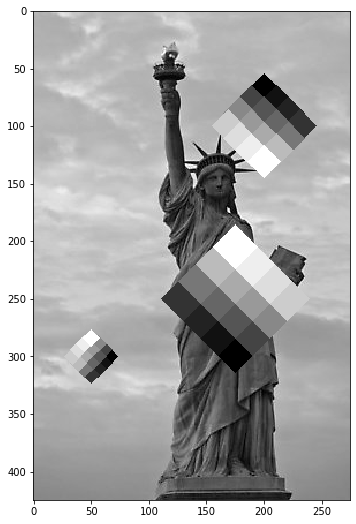

In [183]:
s=3.6
centers = get_descriptor_centers(lady, (100,200), 'pi/4', s)

colors = np.linspace(0,255, 16)

copy = np.ones(copy.shape)
for i in range(copy.shape[0]):
    for j in range(copy.shape[1]):
        copy[i][j] = lady[i][j]
        
count = 0      
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        count += 1
        copy[pt[0]][pt[1]] = colors[i-1]
        
s=1.8
centers = get_descriptor_centers(lady, (300,50), '7pi/4', s)
        
count = 0      
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        count += 1
        copy[pt[0]][pt[1]] = colors[i-1]
        
s=5.2
centers = get_descriptor_centers(lady, (250,175), '5pi/4', s)
        
count = 0      
for i in np.arange(16)+1:
    square = square_around_pt(copy, centers[i], 4*s)
    for pt in square:
        count += 1
        copy[pt[0]][pt[1]] = colors[i-1]
    
plt.figure(figsize=((9,9)))
plt.imshow(copy)
plt.show()   
    

In [158]:
print(count)
print((20*3.6)**2)

1808
5184.0


In [96]:
def get_slanted_region(img, i, j, orientation, s):
    region = square_around_pt(img, i, j, orientation, s)

    max_i = max(region[:,0])
    min_i = min(region[:,0])
    min_j = min(region[:,1])
    max_j = max(region[:,1])

    for pt in region:
        if pt[0] == max_i:
            top_corner = pt
        elif pt[1] ==  min_j:
            left_corner = pt
        elif pt[0] == min_i:
            bottom_corner = pt
        elif pt[1] == max_j:
            right_corner = pt
    
    
    if orientation == 'pi/4':
        first_region = top_corner - 

    output = np.zeros((max_i - right_corner[0]+1, max_i - right_corner[0]+1))
    print(output.shape)
    for i in np.linspace(max_i, right_corner[0], max_i - right_corner[0]+1):
        output[]

get_slanted_descriptor(lady,100,200, 'pi/4',2.4)


(47, 47)
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100


In [69]:
np.linspace(19,5,19-5+1)

array([19., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,
        6.,  5.])